In [1]:
# Suppress Deprecation and Incorrect Usage Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime as dt
import time
import gc
from dateutil.relativedelta import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

%matplotlib inline

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
INPUT_FOLDER = './data'
train_origin = pd.read_csv('{}/train.csv'.format(INPUT_FOLDER))
test_origin = pd.read_csv('{}/test.csv'.format(INPUT_FOLDER))
print(train_origin.shape, test_origin.shape)

(891, 12) (418, 11)


In [3]:
test_origin['Survived'] = 0
test_id = test_origin['PassengerId'][0]
print(test_id)

892


In [4]:
data = pd.concat([train_origin, test_origin])

print(data.shape)
# data.head()

(1309, 12)


## Feature Engineering

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


In [6]:
data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived          0
Ticket            0
dtype: int64

In [7]:
data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [8]:
data['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Sir               1
Dona              1
Mme               1
the Countess      1
Don               1
Jonkheer          1
Lady              1
Capt              1
Name: Title, dtype: int64

In [9]:
major_titles = data['Title'].value_counts()[:4].index.tolist()
major_titles

['Mr', 'Miss', 'Mrs', 'Master']

In [10]:
data.groupby(['Title', 'Sex'])['Title'].count()

Title         Sex   
Capt          male        1
Col           male        4
Don           male        1
Dona          female      1
Dr            female      1
              male        7
Jonkheer      male        1
Lady          female      1
Major         male        2
Master        male       61
Miss          female    260
Mlle          female      2
Mme           female      1
Mr            male      757
Mrs           female    197
Ms            female      2
Rev           male        8
Sir           male        1
the Countess  female      1
Name: Title, dtype: int64

In [11]:
data[:test_id].groupby(['Title', 'Sex'])['Title'].count()

Title         Sex   
Capt          male        1
Col           male        2
Don           male        1
Dr            female      1
              male        6
Jonkheer      male        1
Lady          female      1
Major         male        2
Master        male       40
Miss          female    182
Mlle          female      2
Mme           female      1
Mr            male      518
Mrs           female    125
Ms            female      1
Rev           male        6
Sir           male        1
the Countess  female      1
Name: Title, dtype: int64

In [12]:
data[test_id:].groupby(['Title', 'Sex'])['Title'].count()

Title   Sex   
Col     male        2
Dona    female      1
Dr      male        1
Master  male       21
Miss    female     78
Mr      male      239
Mrs     female     72
Ms      female      1
Rev     male        2
Name: Title, dtype: int64

In [13]:
data[:test_id].groupby(['Title', 'Sex'])['Survived'].mean()

Title         Sex   
Capt          male      0.000000
Col           male      0.500000
Don           male      0.000000
Dr            female    1.000000
              male      0.333333
Jonkheer      male      0.000000
Lady          female    1.000000
Major         male      0.500000
Master        male      0.575000
Miss          female    0.697802
Mlle          female    1.000000
Mme           female    1.000000
Mr            male      0.156371
Mrs           female    0.792000
Ms            female    1.000000
Rev           male      0.000000
Sir           male      1.000000
the Countess  female    1.000000
Name: Survived, dtype: float64

In [14]:
map_title_misc = {'Don': 'Mrs', 'Dona': 'Mrs',  'Capt': 'Mr', 'Col': 'Mr', 'Jonkheer': 'Mr',
                  'Lady': 'Mrs', 'Major': 'Mr', 'Mlle': 'Miss', 'Mme': 'Mrs', 'Rev': 'Mrs', 'Rev': 'Mrs',
                  'Sir' : 'Mr', 'the Countess': 'Mrs', 'Ms': 'Miss'}

In [15]:
def clean_title(row):
    title = row['Title']
    if title in map_title_misc.keys():
        row['Title'] = map_title_misc[title]
    elif title == 'Dr':
        sex = row['Sex']
        row['Title'] = 'Mr' if sex == 'mail' else 'Mrs'
    return row

data = data.apply(clean_title, axis=1)
data['Title'].value_counts()

Mr        766
Miss      264
Mrs       218
Master     61
Name: Title, dtype: int64

In [16]:
def cabin_class(row):
    cabin = str(row['Cabin'])
    row['CabinClass'] = np.nan
    if cabin is not None:
        row['CabinClass'] = cabin[0]
    return row

data = data.apply(cabin_class, axis=1)
data['CabinClass'].value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: CabinClass, dtype: int64

In [17]:
data[:test_id]['CabinClass'].value_counts()

n    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinClass, dtype: int64

In [18]:
data[:test_id].groupby(['CabinClass'])['Survived'].mean()

CabinClass
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299419
Name: Survived, dtype: float64

In [19]:
data[test_id:]['CabinClass'].value_counts()

n    326
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: CabinClass, dtype: int64

In [20]:
data.drop(columns='CabinClass', inplace=True)

In [21]:
data.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)
data.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,S,7.2500,0,1,3,male,1,0,Mr
1,38.0,C,71.2833,0,2,1,female,1,1,Mrs
2,26.0,S,7.9250,0,3,3,female,0,1,Miss
3,35.0,S,53.1000,0,4,1,female,1,1,Mrs
4,35.0,S,8.0500,0,5,3,male,0,0,Mr


In [22]:
data.isnull().sum()

Age            263
Embarked         2
Fare             1
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived         0
Title            0
dtype: int64

In [23]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

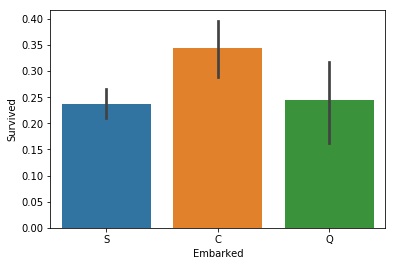

In [24]:
sns.barplot(x = 'Embarked', y = 'Survived', data=data)

In [25]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
data['Embarked'].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

In [26]:
data['Fare'].fillna(data['Fare'].median(), inplace = True)

In [27]:
data['Age'].fillna(data['Age'].median(), inplace = True)

In [28]:
data.isnull().sum()

Age            0
Embarked       0
Fare           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Survived       0
Title          0
dtype: int64

In [29]:
data.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,S,7.2500,0,1,3,male,1,0,Mr
1,38.0,C,71.2833,0,2,1,female,1,1,Mrs
2,26.0,S,7.9250,0,3,3,female,0,1,Miss
3,35.0,S,53.1000,0,4,1,female,1,1,Mrs
4,35.0,S,8.0500,0,5,3,male,0,0,Mr


In [30]:
categorical_features = ['Sex', 'Title', 'Embarked']

In [31]:
def category_to_code(df, categorical_features):
    df_copy = df.copy()
    for feature in categorical_features:
        df_copy[feature] = df_copy[feature].astype('category').cat.codes
    return df_copy

data_code = category_to_code(data, categorical_features)
data_code.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,2,7.2500,0,1,3,1,1,0,2
1,38.0,0,71.2833,0,2,1,0,1,1,3
2,26.0,2,7.9250,0,3,3,0,0,1,1
3,35.0,2,53.1000,0,4,1,0,1,1,3
4,35.0,2,8.0500,0,5,3,1,0,0,2


In [32]:
data_dummy = pd.get_dummies(data)
data_dummy.head()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,22.0,7.2500,0,1,3,1,0,0,0,1,0,1,0,0,1,0
1,38.0,71.2833,0,2,1,1,1,1,0,0,1,0,0,0,0,1
2,26.0,7.9250,0,3,3,0,1,0,0,1,1,0,0,1,0,0
3,35.0,53.1000,0,4,1,1,1,0,0,1,1,0,0,0,0,1
4,35.0,8.0500,0,5,3,0,0,0,0,1,0,1,0,0,1,0


In [33]:
df = data_dummy.loc[data_dummy['PassengerId'] < test_id]
df.drop(columns='PassengerId', inplace=True)

In [34]:
test = data_dummy.loc[data_dummy['PassengerId'] >= test_id]
test.drop(columns=['PassengerId', 'Survived'], inplace=True)

In [35]:
from CrossValidationModel import CrossValidationModel

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [37]:
cvm = CrossValidationModel()
model = RandomForestClassifier(n_estimators=13)
n_splits = 10
target_col = 'Survived'

cvm.fit(model, df, n_splits, 'Survived')

print(cvm.score(accuracy_score))
print(cvm.score(roc_auc_score))

predicts = cvm.predict(test)

for i in range(n_splits):
    print(predicts[i].sum())

[0.8111111111111111, 0.8651685393258427, 0.7752808988764045, 0.8089887640449438, 0.8314606741573034, 0.8089887640449438, 0.8089887640449438, 0.7415730337078652, 0.7640449438202247, 0.8202247191011236]
[0.8031674208144797, 0.8533372365339578, 0.773735810113519, 0.8074074074074075, 0.8163082437275986, 0.7688172043010751, 0.7985875706214689, 0.7267195767195767, 0.7581632653061224, 0.8178721174004193]
163
158
164
169
168
164
171
160
162
159
